# Block image Classification 

## Model Training

In [1]:
import numpy as np


import keras
from keras import layers

import tensorflow as tf
import tensorflow_datasets as tfds

import matplotlib.pyplot as plt

2024-06-04 11:21:32.669765: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-04 11:21:32.673121: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-04 11:21:32.712038: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-04 11:21:34.965997: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:

train_ds = tf.keras.utils.image_dataset_from_directory(
  directory='Fruits/train',
  labels='inferred',
  label_mode='int',
  batch_size=12,
  image_size=(150, 150))

validation_ds = tf.keras.utils.image_dataset_from_directory(
  directory='Fruits/val',
  labels='inferred',
  label_mode='int',
  batch_size=12,
  image_size=(150, 150))




Found 489 files belonging to 3 classes.


Found 489 files belonging to 3 classes.


In [3]:
val_batches = tf.data.experimental.cardinality(validation_ds)
test_ds = validation_ds.take(val_batches // 5)
validation_ds = validation_ds.skip(val_batches // 5)

In [4]:
print('Number of training batches: %d' % tf.data.experimental.cardinality(train_ds))
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_ds))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_ds))

Number of training batches: 41
Number of validation batches: 33
Number of test batches: 8


2024-06-04 11:21:39.267636: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


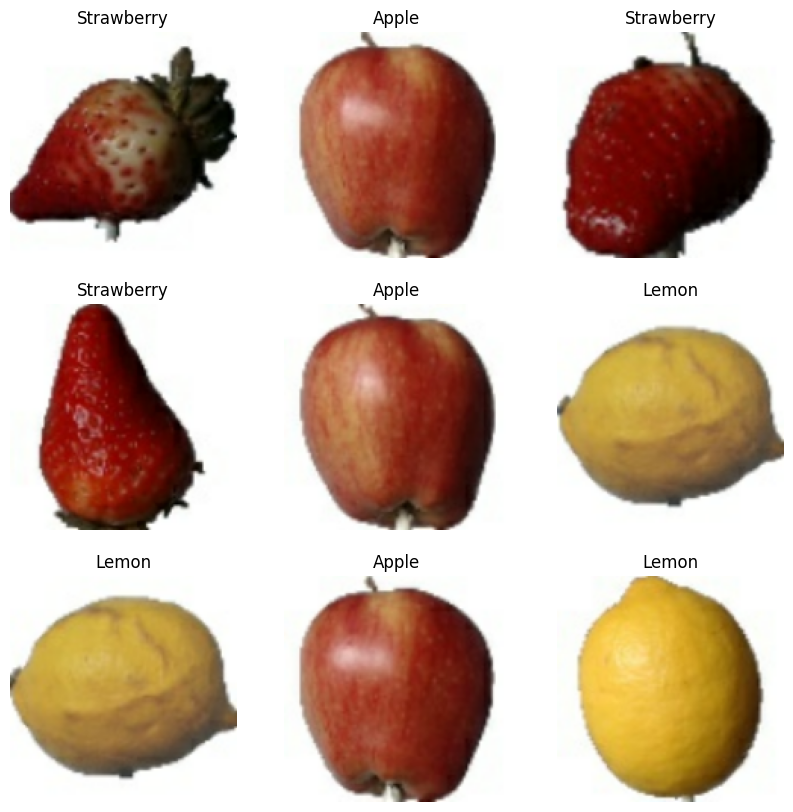

In [5]:
class_names = train_ds.class_names


plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [6]:
number_of_classes = len(train_ds.class_names)

In [7]:
resize_fn = keras.layers.Resizing(150, 150)

train_ds = train_ds.map(lambda x, y: (resize_fn(x), y))
validation_ds = validation_ds.map(lambda x, y: (resize_fn(x), y))
test_ds = test_ds.map(lambda x, y: (resize_fn(x), y))

## Using random data augmentation

In [8]:
data_augmentation = keras.Sequential(
    [
        keras.layers.RandomFlip("horizontal_and_vertical"),
        keras.layers.RandomRotation(0.2),
    ]
)

2024-06-04 11:21:40.771005: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


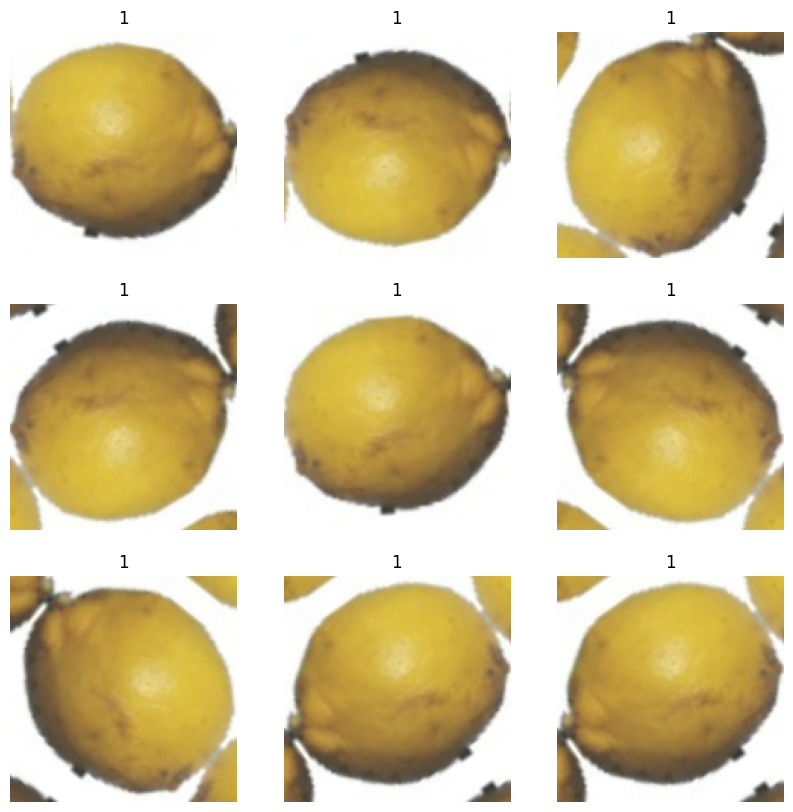

In [9]:
for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    first_image = images[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(np.expand_dims(first_image, 0))
        plt.imshow(np.array(augmented_image[0]).astype("int32"))
        plt.title(int(labels[0]))
        plt.axis("off")

# Data Augmentation

In [10]:
base_model = keras.applications.Xception(
    weights="imagenet",
    input_shape=(150, 150, 3),
    include_top=False,
)

base_model.trainable = False
inputs = keras.Input(shape=(150, 150, 3))
scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
x = scale_layer(inputs)
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)
outputs = keras.layers.Dense(number_of_classes, activation="softmax")(x)
model = keras.Model(inputs, outputs)

In [11]:

model.compile(optimizer=keras.optimizers.Adam(),
              loss="sparse_categorical_crossentropy",
              metrics=['accuracy'])

# Trainieren des Modells
initial_epochs = 4
print("Fitting the top layer of the model")
history = model.fit(train_ds, epochs=initial_epochs, validation_data=validation_ds)

Fitting the top layer of the model
Epoch 1/4
41/41 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step - accuracy: 0.8498 - loss: 0.4637 - val_accuracy: 1.0000 - val_loss: 0.0026
Epoch 2/4
41/41 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step - accuracy: 1.0000 - loss: 0.0027 - val_accuracy: 1.0000 - val_loss: 0.0016
Epoch 3/4
41/41 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step - accuracy: 1.0000 - loss: 0.0021 - val_accuracy: 1.0000 - val_loss: 0.0012
Epoch 4/4
41/41 ━━━━━━━━━━━━━━━━━━━━ 47s 1s/step - accuracy: 1.0000 - loss: 0.0014 - val_accuracy: 1.0000 - val_loss: 0.0010


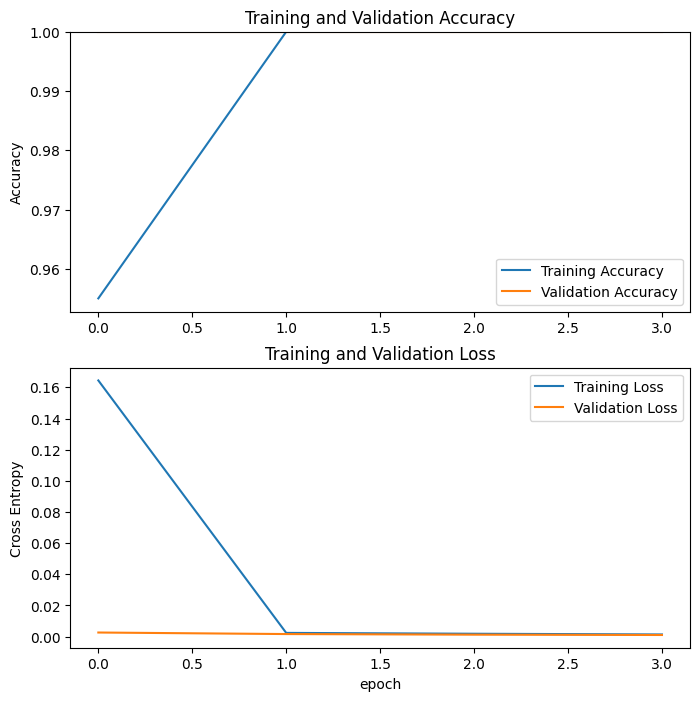

In [12]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [13]:
base_model.trainable = True
model.summary(show_trainable=True)

model.compile(
    optimizer=keras.optimizers.Adam(1e-5),  
    loss="sparse_categorical_crossentropy",
    metrics=['accuracy']
)

epochs = 1
print("Fitting the end-to-end model")
history_fine = model.fit(train_ds, epochs=epochs, validation_data=validation_ds)

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer_2 (InputLayer)  │ (None, 150, 150, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ rescaling (Rescaling)       │ (None, 150, 150, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ xception (Functional)       │ (None, 5, 5, 2048)    │ 20,861,480 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ global_average_pooling2d    │ (None, 2048)          │          0 │   -   │
│ (GlobalAveragePooling2D)    │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dropout (Dropout)           │ (None, 2048)          │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense (Dense)               │ (None, 3)             │      6,147 │   Y   │
└─────────────────────────────┴───────────────────────┴────────────┴───────┘

 Total params: 20,879,923 (79.65 MB)

 Trainable params: 20,813,099 (79.40 MB)

 Non-trainable params: 54,528 (213.00 KB)

 Optimizer params: 12,296 (48.04 KB)

Fitting the end-to-end model
41/41 ━━━━━━━━━━━━━━━━━━━━ 151s 3s/step - accuracy: 0.8170 - loss: 0.5499 - val_accuracy: 1.0000 - val_loss: 0.0015


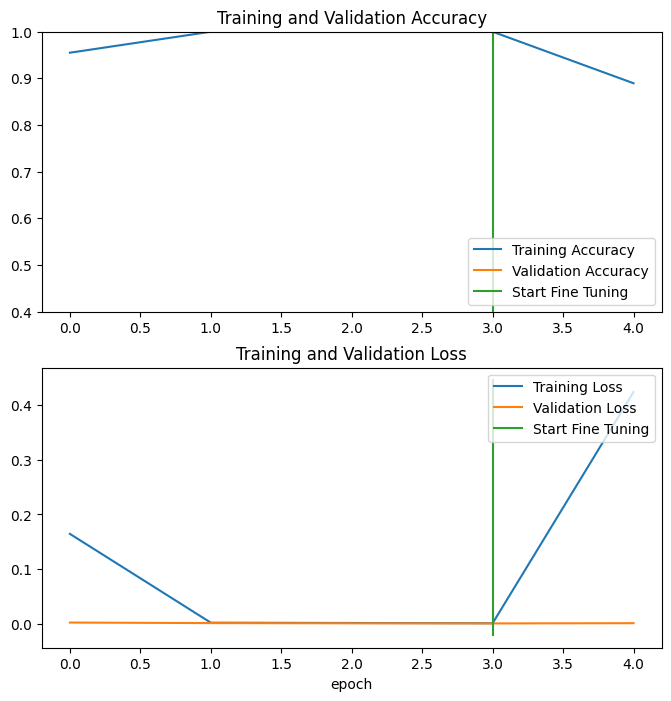

In [14]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.4, 1]) 
plt.plot([initial_epochs-1,initial_epochs-1],
plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.plot([initial_epochs-1,initial_epochs-1],
plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [15]:
print("Test dataset evaluation")
model.evaluate(test_ds)

Test dataset evaluation
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 636ms/step - accuracy: 1.0000 - loss: 0.0014


[0.0013743879972025752, 1.0]

Predictions:
 [0 2 0 2 2 0 0 0 0 0 1 2]
Labels:
 [0 2 0 2 2 0 0 0 0 0 1 2]


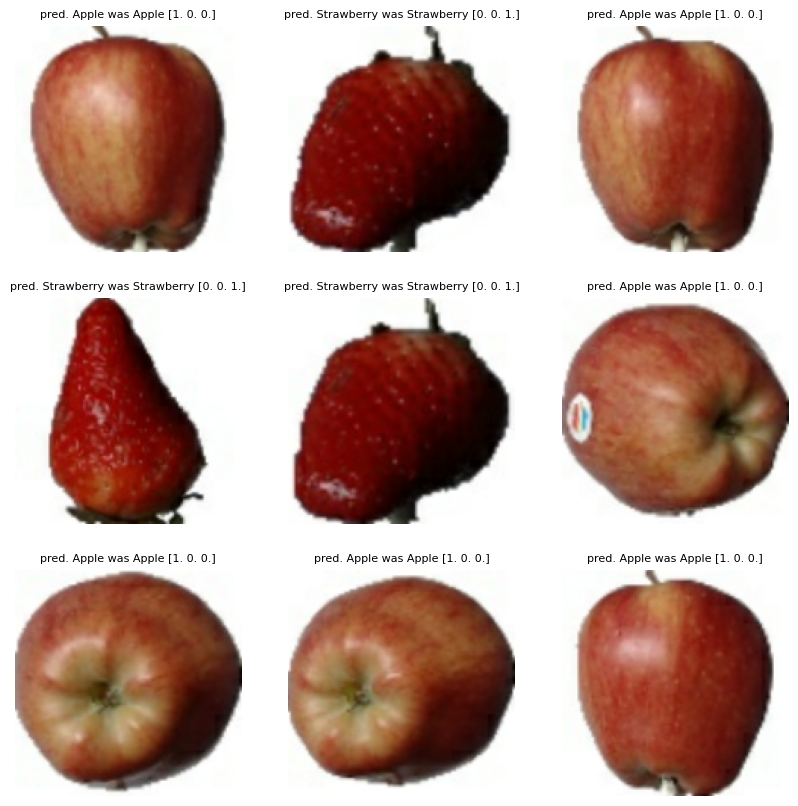

In [16]:
image_batch, label_batch = test_ds.as_numpy_iterator().next()
predictions_in_percentage = model.predict_on_batch(image_batch)
predictions = np.argmax(predictions_in_percentage, axis=-1)
print('Predictions:\n', predictions)
print('Labels:\n', label_batch)
plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title('pred. ' + class_names[predictions[i]] + ' was ' + class_names[label_batch[i]] + ' ' + 	str(np.round(predictions_in_percentage[i], 2)), fontsize=8)
  plt.axis("off")

In [17]:
model.save('Fruits_fruits.keras')

What was the base model you used:
The base model used for the transfer learning project was Xception, pretrained on the ImageNet dataset, utilized via the tensorflow.keras.applications API

What was the performance of the model after transfer-learning, before unfreezing the layers of the base model?
After the initial transfer learning phase and before unfreezing the base model layers, the model achieved a validation accuracy of 97.13%.

What was the performance after fine-tuning?
Following the fine-tuning phase, where additional layers of the base model were unfrozen and the entire model was retrained, the validation accuracy improved to 97.74%.

What Pokémon did you choose?
Lickitung, Nidoking, Pikachu